In [1]:
import os, numpy as np, agama, scipy.special, scipy.integrate, matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pyfalcon
from IPython.display import Latex
import plotly.express as px
agama.setUnits(length=1, velocity=1, mass=1) #kpc,km/s, Solar mass

Velocity dispersion


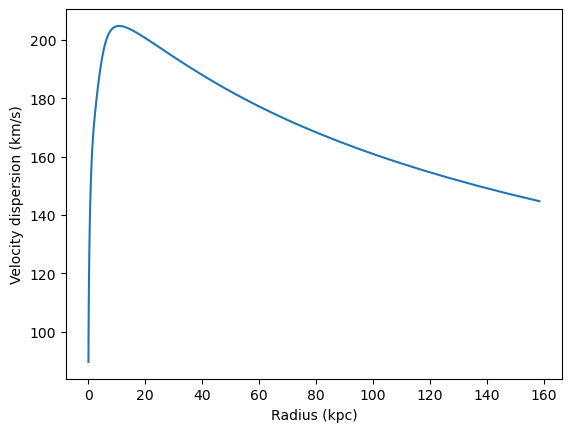

In [2]:
pot_mw = agama.Potential(
    dict(type='Dehnen', mass=1.0e10, scaleRadius=1.0, gamma=1),  # Bulge
    dict(type='MiyamotoNagai', mass=5.0e10, scaleRadius=3.0, scaleHeight=0.3),  # Disk
    dict(type='NFW', mass=2e12, scaleRadius=22.0))  # Dark matter halo
df_mw = agama.DistributionFunction(type='quasispherical', potential=pot_mw)
r_array  = np.logspace(-1, 2.2, 100)
sigma_array= agama.GalaxyModel(pot_mw,df_mw).moments(np.column_stack((r_array, r_array*0, r_array*0)), dens=False, vel=False, vel2=True)[:,0]**0.5

plt.plot(r_array, sigma_array) 
plt.xlabel('Radius (kpc)')
plt.ylabel('Velocity dispersion (km/s)')
print('Velocity dispersion')

Density profile MW


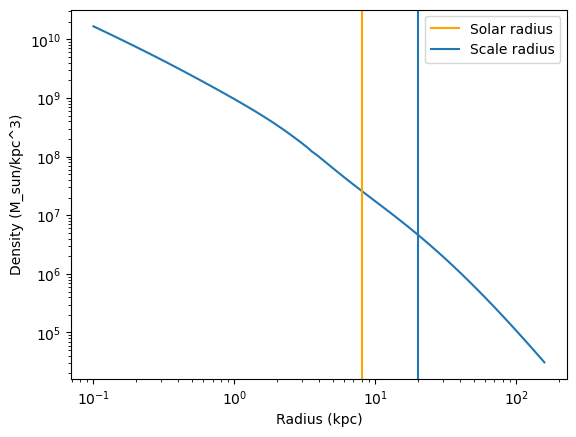

In [3]:
#Non-essential
rho_array= agama.GalaxyModel(pot_mw,df_mw).moments(np.column_stack((r_array, r_array*0, r_array*0)), dens=True, vel=False, vel2=False)
plt.loglog(r_array, rho_array)
plt.axvline(8.0, color='orange', label='Solar radius')
plt.axvline(20.0, label='Scale radius')
print('Density profile MW')
plt.xlabel('Radius (kpc)')
plt.ylabel('Density (M_sun/kpc^3)')
plt.legend()

In [4]:
#Extrapolate sigma(r) using a log-log spline
logspl  = agama.Spline(np.log(r_array), np.log(sigma_array))
sigma   = lambda r: np.exp(logspl(np.log(r))) 


In [5]:
mc_mass0=1e-7
mc_rvir=1e-4
mc_rs=1e-5
Nbody=10000

In [6]:
#pot_mc= agama.Potential(type='NFW',mass=1e-7,scaleRadius=1e-9)
pot_mc  = agama.Potential(type='spheroid', gamma=1.5, beta=3, scaleradius=mc_rs, outercutoffradius=mc_rvir, mass=mc_mass0)
df_mc = agama.DistributionFunction(type='quasispherical', potential=pot_mc)
mc_mass0 = pot_mc.totalMass()

Density profile MC


Text(0, 0.5, 'Density (M_sun/kpc^3)')

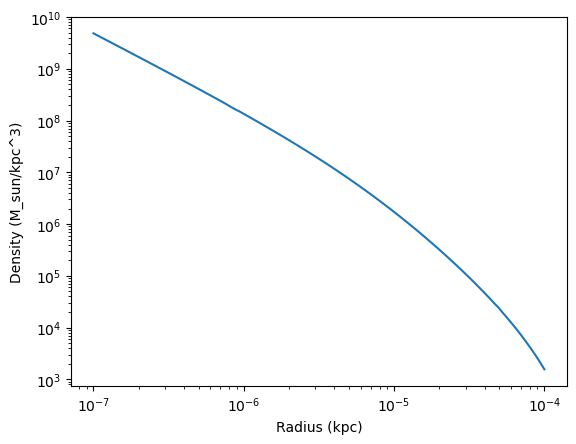

In [7]:
#Non-essential
r_mc=np.logspace(-7,-4,100)
rho_array_mc= agama.GalaxyModel(pot_mc,df_mc).moments(np.column_stack((r_mc, r_mc*0, r_mc*0)), dens=True, vel=False, vel2=False)
plt.loglog(r_mc, rho_array_mc)
print('Density profile MC')
plt.xlabel('Radius (kpc)')
plt.ylabel('Density (M_sun/kpc^3)')


In [8]:
mcp_xv, mcp_mass = agama.GalaxyModel(pot_mc, df_mc).sample(Nbody)

R0 = 8
Y0 = 0
Z0=-1
F=pot_mw.force(R0,Y0,Z0)
Vx0 = 0
Vy0 = 0
Vz0 = 220
Vx=Vx0
Vy=Vy0
Vz=Vz0
mc_center = np.array([R0, Y0, Z0, Vx, Vy, Vz])
#putting the mc particles in the mw frame
mcp_xv+= mc_center

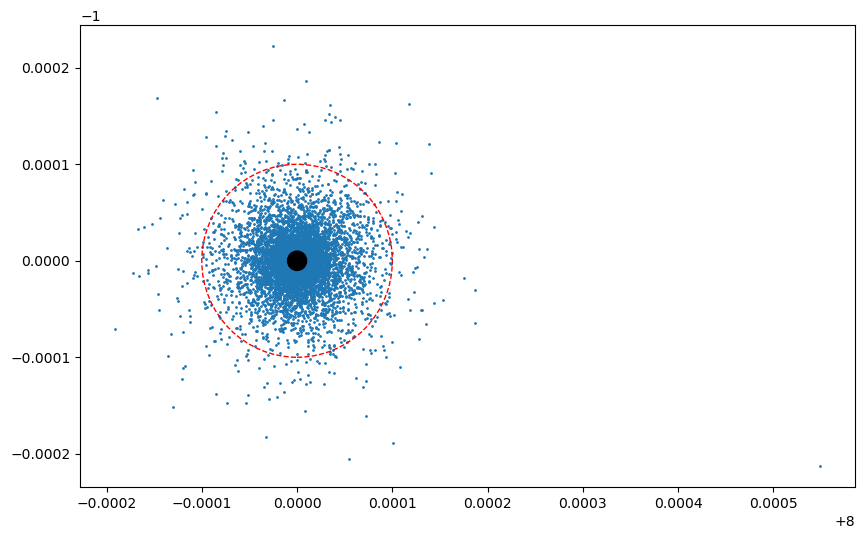

In [9]:
fig,ax_i=plt.subplots(figsize=(10,6))
ax_i.scatter(mcp_xv[:,0], mcp_xv[:,2], s=1)
Radial_cirlce=plt.Circle((8,-1), mc_rvir, color='r', fill=False, linestyle='--')
Scaleradius_cirlce=plt.Circle((8,-1), mc_rs, color='k', fill=True)

ax_i.add_patch(Radial_cirlce)
ax_i.add_patch(Scaleradius_cirlce)


In [10]:
def dynfricAccel(pos, vel, mass):
    r   = sum(pos**2)**0.5
    v   = sum(vel**2)**0.5
    rho = pot_mw.density(pos)
    coulombLog = 3.0
    X = v / (2**0.5 * sigma(r))
    return -vel / v * ((4*np.pi * agama.G**2 * mass * rho * coulombLog/ v**2) *
        (scipy.special.erf(X) - 2/np.pi**.5 * X * np.exp(-X**2)) )
print('Dynamical friction formula use:')
Latex(r"$$\vec{a}_{\mathrm{df}} = - \frac{4 \pi G^2 M \rho \ln\Lambda}{v^2} \left[ \mathrm{erf}(X) - \frac{2X}{\sqrt{\pi}} e^{-X^2} \right] \frac{\vec{v}}{v}$$")


Dynamical friction formula use:


<IPython.core.display.Latex object>

In [11]:
def orbitDF(ic, time, timestart, trajsize, mass):
    if mass == 0:
        return agama.orbit(ic=ic, potential=pot_mw, time=time, timestart=timestart, trajsize=trajsize,accuracy=1e-10)
    times = np.linspace(timestart, timestart+time, trajsize)
    #traj = scipy.integrate.odeint(
       # lambda xv, t: np.hstack((xv[3:6], pot_mw.force(xv[0:3], t=t) + 0*dynfricAccel(xv[0:3], xv[3:6], mc_mass0
        #) )),
        #ic, times,rtol=1e-10,atol=1e-12)
    sol=solve_ivp(
        lambda t, xv: np.hstack((xv[3:6], 
                                pot_mw.force(xv[0:3], t=t) + 
                                dynfricAccel(xv[0:3], xv[3:6], mass))),
        [timestart, timestart+time],
        ic,
        method='DOP853',
        t_eval=times,
        rtol=1e-14,
        atol=1e-16
    )

    #return times, traj
    return sol.t, sol.y.T

In [12]:
orbit_time=pot_mw.Tcirc(mc_center)
print(orbit_time)

0.16555911786586966


In [13]:

simulation_time=2*orbit_time
tupd = 1e-3 # interval for plotting and updating the satellite mass for the restricted N-body simulation
tau  = 1e-4 # timestep of the full N-body sim (typically should be smaller than softening_length/v, where v is characteristic internal velocity)
softening_length  = 1e-5   # softening length for the full N-body simulation


time     = 0.0  
times_t  = [time]
times_u  = [time]
mc_mass   = [mc_mass0]
mc_traj   = [mc_center]
bound_energy  = np.ones(len(mcp_xv), bool)
bound_dist  = np.ones(len(mcp_xv), bool)


time_i=0

In [14]:
while time_i<simulation_time:
    mc_time_center,mc_orbit_center=orbitDF(ic=mc_center,time=tupd,timestart=time_i,trajsize=10000,mass=mc_mass[-1] )
    times_u.append(mc_time_center[-1])
    times_t.extend(mc_time_center[1:])
    mc_traj.extend(mc_orbit_center[1:])
    
    mc_center=mc_orbit_center[-1]
    pot_total=agama.Potential(pot_mw,agama.Potential(potential=pot_mc, center=np.column_stack((mc_time_center, mc_orbit_center))))
    mcp_xv = np.vstack(agama.orbit(ic=mcp_xv, potential=pot_total, time=tupd, timestart=time_i, trajsize=1,accuracy=1e-10)[:,1])
    pot_mc = agama.Potential(type='multipole', particles=(mcp_xv[:,0:3] - mc_center[0:3], mcp_mass), symmetry='a', lmax=4)   
    bound_energy = pot_mc.potential(mcp_xv[:,0:3] - mc_center[0:3]) + 0.5 * np.sum((mcp_xv[:,3:6] - mc_center[3:6])**2, axis=1) < 0
    bound_dist=np.sum((mcp_xv[:,0:3] - mc_center[0:3])**2, axis=1) < mc_rvir**2
    bound=bound_dist& bound_energy
    mc_mass.append(np.sum(mcp_mass[bound])) 
    time_i+=tupd
    print(time_i)



/opt/anaconda3/envs/minicluster/lib/python3.13/site-packages/scipy/integrate/_ivp/rk.py:505: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  super().__init__(fun, t0, y0, t_bound, max_step, rtol, atol,
10000 orbits complete (185185 orbits/s)
10000 orbits complete (185185 orbits/s)


0.001
0.002
0.003


10000 orbits complete (151515 orbits/s)
10000 orbits complete (185185 orbits/s)
10000 orbits complete (178571 orbits/s)


0.004
0.005
0.006


10000 orbits complete (181818 orbits/s)
10000 orbits complete (188679 orbits/s)
10000 orbits complete (185185 orbits/s)


0.007
0.008
0.009000000000000001


10000 orbits complete (185185 orbits/s)
10000 orbits complete (181818 orbits/s)
10000 orbits complete (192308 orbits/s)


0.010000000000000002
0.011000000000000003
0.012000000000000004


10000 orbits complete (181818 orbits/s)
10000 orbits complete (188679 orbits/s)
10000 orbits complete (196078 orbits/s)


0.013000000000000005
0.014000000000000005
0.015000000000000006


10000 orbits complete (188679 orbits/s)
10000 orbits complete (188679 orbits/s)
10000 orbits complete (196078 orbits/s)


0.016000000000000007
0.017000000000000008
0.01800000000000001


10000 orbits complete (192308 orbits/s)
10000 orbits complete (188679 orbits/s)
10000 orbits complete (192308 orbits/s)


0.01900000000000001
0.02000000000000001
0.02100000000000001


10000 orbits complete (192308 orbits/s)
10000 orbits complete (192308 orbits/s)
10000 orbits complete (192308 orbits/s)


0.022000000000000013
0.023000000000000013
0.024000000000000014


10000 orbits complete (188679 orbits/s)
10000 orbits complete (188679 orbits/s)
10000 orbits complete (192308 orbits/s)


0.025000000000000015
0.026000000000000016
0.027000000000000017


10000 orbits complete (192308 orbits/s)
10000 orbits complete (192308 orbits/s)
10000 orbits complete (192308 orbits/s)


0.028000000000000018
0.02900000000000002
0.03000000000000002


10000 orbits complete (192308 orbits/s)
10000 orbits complete (142857 orbits/s)
10000 orbits complete (204082 orbits/s)


0.03100000000000002
0.03200000000000002
0.03300000000000002


10000 orbits complete (196078 orbits/s)
10000 orbits complete (192308 orbits/s)
10000 orbits complete (196078 orbits/s)


0.03400000000000002
0.035000000000000024
0.036000000000000025


10000 orbits complete (192308 orbits/s)
10000 orbits complete (192308 orbits/s)
10000 orbits complete (192308 orbits/s)


0.037000000000000026
0.03800000000000003
0.03900000000000003


10000 orbits complete (192308 orbits/s)
10000 orbits complete (192308 orbits/s)
10000 orbits complete (192308 orbits/s)


0.04000000000000003
0.04100000000000003
0.04200000000000003


10000 orbits complete (192308 orbits/s)
10000 orbits complete (192308 orbits/s)
10000 orbits complete (192308 orbits/s)


0.04300000000000003
0.04400000000000003
0.04500000000000003


10000 orbits complete (192308 orbits/s)
10000 orbits complete (192308 orbits/s)
10000 orbits complete (192308 orbits/s)


0.046000000000000034
0.047000000000000035
0.048000000000000036


10000 orbits complete (185185 orbits/s)
10000 orbits complete (192308 orbits/s)
10000 orbits complete (192308 orbits/s)


0.04900000000000004
0.05000000000000004
0.05100000000000004


10000 orbits complete (188679 orbits/s)
10000 orbits complete (188679 orbits/s)
10000 orbits complete (196078 orbits/s)


0.05200000000000004
0.05300000000000004
0.05400000000000004


10000 orbits complete (188679 orbits/s)
10000 orbits complete (185185 orbits/s)
10000 orbits complete (204082 orbits/s)


0.05500000000000004
0.05600000000000004
0.057000000000000044


10000 orbits complete (144928 orbits/s)
10000 orbits complete (188679 orbits/s)
10000 orbits complete (192308 orbits/s)


0.058000000000000045
0.059000000000000045
0.060000000000000046


10000 orbits complete (188679 orbits/s)
10000 orbits complete (188679 orbits/s)
10000 orbits complete (196078 orbits/s)


0.06100000000000005
0.06200000000000005
0.06300000000000004


10000 orbits complete (185185 orbits/s)
10000 orbits complete (188679 orbits/s)
10000 orbits complete (196078 orbits/s)


0.06400000000000004
0.06500000000000004
0.06600000000000004


10000 orbits complete (185185 orbits/s)
10000 orbits complete (185185 orbits/s)
10000 orbits complete (204082 orbits/s)


0.06700000000000005
0.06800000000000005
0.06900000000000005


10000 orbits complete (188679 orbits/s)
10000 orbits complete (188679 orbits/s)
10000 orbits complete (192308 orbits/s)


0.07000000000000005
0.07100000000000005
0.07200000000000005


10000 orbits complete (188679 orbits/s)
10000 orbits complete (192308 orbits/s)
10000 orbits complete (196078 orbits/s)


0.07300000000000005
0.07400000000000005
0.07500000000000005


10000 orbits complete (192308 orbits/s)
10000 orbits complete (185185 orbits/s)
10000 orbits complete (188679 orbits/s)


0.07600000000000005
0.07700000000000005
0.07800000000000006


10000 orbits complete (188679 orbits/s)
10000 orbits complete (188679 orbits/s)
10000 orbits complete (196078 orbits/s)


0.07900000000000006
0.08000000000000006
0.08100000000000006


10000 orbits complete (196078 orbits/s)
10000 orbits complete (192308 orbits/s)
10000 orbits complete (200000 orbits/s)


0.08200000000000006
0.08300000000000006
0.08400000000000006


10000 orbits complete (188679 orbits/s)
10000 orbits complete (192308 orbits/s)
10000 orbits complete (192308 orbits/s)


0.08500000000000006
0.08600000000000006
0.08700000000000006


10000 orbits complete (147059 orbits/s)
10000 orbits complete (200000 orbits/s)
10000 orbits complete (196078 orbits/s)


0.08800000000000006
0.08900000000000007
0.09000000000000007


10000 orbits complete (188679 orbits/s)
10000 orbits complete (188679 orbits/s)
10000 orbits complete (196078 orbits/s)


0.09100000000000007
0.09200000000000007
0.09300000000000007


10000 orbits complete (192308 orbits/s)
10000 orbits complete (192308 orbits/s)
10000 orbits complete (196078 orbits/s)


0.09400000000000007
0.09500000000000007
0.09600000000000007


10000 orbits complete (188679 orbits/s)
10000 orbits complete (192308 orbits/s)
10000 orbits complete (192308 orbits/s)


0.09700000000000007
0.09800000000000007
0.09900000000000007


10000 orbits complete (188679 orbits/s)
10000 orbits complete (188679 orbits/s)
10000 orbits complete (196078 orbits/s)


0.10000000000000007
0.10100000000000008
0.10200000000000008


10000 orbits complete (188679 orbits/s)
10000 orbits complete (192308 orbits/s)
10000 orbits complete (200000 orbits/s)


0.10300000000000008
0.10400000000000008
0.10500000000000008


10000 orbits complete (192308 orbits/s)
10000 orbits complete (188679 orbits/s)
10000 orbits complete (200000 orbits/s)


0.10600000000000008
0.10700000000000008
0.10800000000000008


10000 orbits complete (188679 orbits/s)
10000 orbits complete (192308 orbits/s)
10000 orbits complete (196078 orbits/s)


0.10900000000000008
0.11000000000000008
0.11100000000000008


10000 orbits complete (196078 orbits/s)
10000 orbits complete (200000 orbits/s)
10000 orbits complete (200000 orbits/s)


0.11200000000000009
0.11300000000000009
0.11400000000000009


10000 orbits complete (196078 orbits/s)
10000 orbits complete (196078 orbits/s)
10000 orbits complete (196078 orbits/s)


0.11500000000000009
0.11600000000000009
0.11700000000000009


10000 orbits complete (158730 orbits/s)
10000 orbits complete (196078 orbits/s)
10000 orbits complete (200000 orbits/s)


0.11800000000000009
0.11900000000000009
0.12000000000000009


10000 orbits complete (188679 orbits/s)
10000 orbits complete (192308 orbits/s)
10000 orbits complete (192308 orbits/s)


0.1210000000000001
0.1220000000000001
0.1230000000000001


10000 orbits complete (192308 orbits/s)
10000 orbits complete (188679 orbits/s)
10000 orbits complete (196078 orbits/s)


0.1240000000000001
0.12500000000000008
0.12600000000000008


10000 orbits complete (192308 orbits/s)
10000 orbits complete (192308 orbits/s)
10000 orbits complete (192308 orbits/s)


0.12700000000000009
0.12800000000000009
0.1290000000000001


10000 orbits complete (192308 orbits/s)
10000 orbits complete (192308 orbits/s)
10000 orbits complete (200000 orbits/s)


0.1300000000000001
0.1310000000000001
0.1320000000000001


10000 orbits complete (196078 orbits/s)
10000 orbits complete (196078 orbits/s)
10000 orbits complete (196078 orbits/s)


0.1330000000000001
0.1340000000000001
0.1350000000000001


10000 orbits complete (192308 orbits/s)
10000 orbits complete (192308 orbits/s)
10000 orbits complete (196078 orbits/s)


0.1360000000000001
0.1370000000000001
0.1380000000000001


10000 orbits complete (192308 orbits/s)
10000 orbits complete (192308 orbits/s)
10000 orbits complete (196078 orbits/s)


0.1390000000000001
0.1400000000000001
0.1410000000000001


10000 orbits complete (192308 orbits/s)
10000 orbits complete (175439 orbits/s)
10000 orbits complete (196078 orbits/s)


0.1420000000000001
0.1430000000000001
0.1440000000000001


10000 orbits complete (192308 orbits/s)
10000 orbits complete (196078 orbits/s)
10000 orbits complete (196078 orbits/s)


0.1450000000000001
0.1460000000000001
0.1470000000000001


10000 orbits complete (153846 orbits/s)
10000 orbits complete (200000 orbits/s)
10000 orbits complete (192308 orbits/s)


0.1480000000000001
0.1490000000000001
0.1500000000000001


10000 orbits complete (188679 orbits/s)
10000 orbits complete (192308 orbits/s)
10000 orbits complete (196078 orbits/s)


0.1510000000000001
0.1520000000000001
0.1530000000000001


10000 orbits complete (200000 orbits/s)
10000 orbits complete (196078 orbits/s)
10000 orbits complete (200000 orbits/s)


0.1540000000000001
0.1550000000000001
0.1560000000000001


10000 orbits complete (204082 orbits/s)
10000 orbits complete (192308 orbits/s)
10000 orbits complete (196078 orbits/s)


0.1570000000000001
0.1580000000000001
0.1590000000000001


10000 orbits complete (192308 orbits/s)
10000 orbits complete (192308 orbits/s)
10000 orbits complete (196078 orbits/s)


0.16000000000000011
0.16100000000000012
0.16200000000000012


10000 orbits complete (192308 orbits/s)
10000 orbits complete (192308 orbits/s)
10000 orbits complete (196078 orbits/s)


0.16300000000000012
0.16400000000000012
0.16500000000000012


10000 orbits complete (196078 orbits/s)
10000 orbits complete (185185 orbits/s)
10000 orbits complete (188679 orbits/s)


0.16600000000000012
0.16700000000000012
0.16800000000000012


10000 orbits complete (188679 orbits/s)
10000 orbits complete (185185 orbits/s)
10000 orbits complete (196078 orbits/s)


0.16900000000000012
0.17000000000000012
0.17100000000000012


10000 orbits complete (196078 orbits/s)
10000 orbits complete (158730 orbits/s)
10000 orbits complete (200000 orbits/s)


0.17200000000000013
0.17300000000000013
0.17400000000000013


10000 orbits complete (192308 orbits/s)
10000 orbits complete (196078 orbits/s)
10000 orbits complete (192308 orbits/s)


0.17500000000000013
0.17600000000000013
0.17700000000000013


10000 orbits complete (192308 orbits/s)
10000 orbits complete (192308 orbits/s)
10000 orbits complete (200000 orbits/s)


0.17800000000000013
0.17900000000000013
0.18000000000000013


10000 orbits complete (208333 orbits/s)
10000 orbits complete (196078 orbits/s)
10000 orbits complete (200000 orbits/s)


0.18100000000000013
0.18200000000000013
0.18300000000000013


10000 orbits complete (200000 orbits/s)
10000 orbits complete (196078 orbits/s)
10000 orbits complete (204082 orbits/s)


0.18400000000000014
0.18500000000000014
0.18600000000000014


10000 orbits complete (204082 orbits/s)
10000 orbits complete (196078 orbits/s)
10000 orbits complete (200000 orbits/s)


0.18700000000000014
0.18800000000000014
0.18900000000000014


10000 orbits complete (192308 orbits/s)
10000 orbits complete (200000 orbits/s)
10000 orbits complete (196078 orbits/s)


0.19000000000000014
0.19100000000000014
0.19200000000000014


10000 orbits complete (196078 orbits/s)
10000 orbits complete (196078 orbits/s)
10000 orbits complete (196078 orbits/s)


0.19300000000000014
0.19400000000000014
0.19500000000000015


10000 orbits complete (196078 orbits/s)
10000 orbits complete (200000 orbits/s)
10000 orbits complete (200000 orbits/s)


0.19600000000000015
0.19700000000000015
0.19800000000000015


10000 orbits complete (192308 orbits/s)
10000 orbits complete (192308 orbits/s)
10000 orbits complete (200000 orbits/s)


0.19900000000000015
0.20000000000000015
0.20100000000000015


10000 orbits complete (166667 orbits/s)
10000 orbits complete (192308 orbits/s)
10000 orbits complete (196078 orbits/s)


0.20200000000000015
0.20300000000000015
0.20400000000000015


10000 orbits complete (192308 orbits/s)
10000 orbits complete (200000 orbits/s)
10000 orbits complete (196078 orbits/s)


0.20500000000000015
0.20600000000000016
0.20700000000000016


10000 orbits complete (192308 orbits/s)
10000 orbits complete (192308 orbits/s)
10000 orbits complete (196078 orbits/s)


0.20800000000000016
0.20900000000000016
0.21000000000000016


10000 orbits complete (196078 orbits/s)
10000 orbits complete (196078 orbits/s)
10000 orbits complete (196078 orbits/s)


0.21100000000000016
0.21200000000000016
0.21300000000000016


10000 orbits complete (196078 orbits/s)
10000 orbits complete (196078 orbits/s)
10000 orbits complete (192308 orbits/s)


0.21400000000000016
0.21500000000000016
0.21600000000000016


10000 orbits complete (196078 orbits/s)
10000 orbits complete (192308 orbits/s)
10000 orbits complete (196078 orbits/s)


0.21700000000000016
0.21800000000000017
0.21900000000000017


10000 orbits complete (188679 orbits/s)
10000 orbits complete (192308 orbits/s)
10000 orbits complete (192308 orbits/s)


0.22000000000000017
0.22100000000000017
0.22200000000000017


10000 orbits complete (192308 orbits/s)
10000 orbits complete (192308 orbits/s)
10000 orbits complete (196078 orbits/s)


0.22300000000000017
0.22400000000000017
0.22500000000000017


10000 orbits complete (200000 orbits/s)
10000 orbits complete (192308 orbits/s)
10000 orbits complete (204082 orbits/s)


0.22600000000000017
0.22700000000000017
0.22800000000000017


10000 orbits complete (200000 orbits/s)
10000 orbits complete (196078 orbits/s)
10000 orbits complete (208333 orbits/s)


0.22900000000000018
0.23000000000000018
0.23100000000000018


10000 orbits complete (200000 orbits/s)
10000 orbits complete (208333 orbits/s)
10000 orbits complete (200000 orbits/s)


0.23200000000000018
0.23300000000000018
0.23400000000000018


10000 orbits complete (185185 orbits/s)
10000 orbits complete (196078 orbits/s)
10000 orbits complete (200000 orbits/s)


0.23500000000000018
0.23600000000000018
0.23700000000000018


10000 orbits complete (192308 orbits/s)
10000 orbits complete (196078 orbits/s)
10000 orbits complete (200000 orbits/s)


0.23800000000000018
0.23900000000000018
0.24000000000000019


10000 orbits complete (192308 orbits/s)
10000 orbits complete (192308 orbits/s)
10000 orbits complete (200000 orbits/s)


0.2410000000000002
0.2420000000000002
0.2430000000000002


10000 orbits complete (196078 orbits/s)
10000 orbits complete (200000 orbits/s)
10000 orbits complete (196078 orbits/s)


0.2440000000000002
0.2450000000000002
0.2460000000000002


10000 orbits complete (185185 orbits/s)
10000 orbits complete (196078 orbits/s)
10000 orbits complete (196078 orbits/s)


0.2470000000000002
0.2480000000000002
0.2490000000000002


10000 orbits complete (144928 orbits/s)
10000 orbits complete (196078 orbits/s)
10000 orbits complete (196078 orbits/s)


0.25000000000000017
0.25100000000000017
0.25200000000000017


10000 orbits complete (192308 orbits/s)
10000 orbits complete (196078 orbits/s)
10000 orbits complete (204082 orbits/s)


0.25300000000000017
0.25400000000000017
0.25500000000000017


10000 orbits complete (192308 orbits/s)
10000 orbits complete (192308 orbits/s)
10000 orbits complete (192308 orbits/s)


0.25600000000000017
0.2570000000000002
0.2580000000000002


10000 orbits complete (192308 orbits/s)
10000 orbits complete (192308 orbits/s)
10000 orbits complete (196078 orbits/s)


0.2590000000000002
0.2600000000000002
0.2610000000000002


10000 orbits complete (192308 orbits/s)
10000 orbits complete (192308 orbits/s)
10000 orbits complete (192308 orbits/s)


0.2620000000000002
0.2630000000000002
0.2640000000000002


10000 orbits complete (200000 orbits/s)
10000 orbits complete (192308 orbits/s)
10000 orbits complete (192308 orbits/s)


0.2650000000000002
0.2660000000000002
0.2670000000000002


10000 orbits complete (192308 orbits/s)
10000 orbits complete (192308 orbits/s)
10000 orbits complete (196078 orbits/s)


0.2680000000000002
0.2690000000000002
0.2700000000000002


10000 orbits complete (192308 orbits/s)
10000 orbits complete (192308 orbits/s)
10000 orbits complete (200000 orbits/s)


0.2710000000000002
0.2720000000000002
0.2730000000000002


10000 orbits complete (188679 orbits/s)
10000 orbits complete (192308 orbits/s)
10000 orbits complete (196078 orbits/s)


0.2740000000000002
0.2750000000000002
0.2760000000000002


10000 orbits complete (196078 orbits/s)
10000 orbits complete (158730 orbits/s)
10000 orbits complete (196078 orbits/s)


0.2770000000000002
0.2780000000000002
0.2790000000000002


10000 orbits complete (200000 orbits/s)
10000 orbits complete (200000 orbits/s)
10000 orbits complete (200000 orbits/s)


0.2800000000000002
0.2810000000000002
0.2820000000000002


10000 orbits complete (192308 orbits/s)
10000 orbits complete (196078 orbits/s)
10000 orbits complete (200000 orbits/s)


0.2830000000000002
0.2840000000000002
0.2850000000000002


10000 orbits complete (192308 orbits/s)
10000 orbits complete (196078 orbits/s)
10000 orbits complete (200000 orbits/s)


0.2860000000000002
0.2870000000000002
0.2880000000000002


10000 orbits complete (192308 orbits/s)
10000 orbits complete (188679 orbits/s)
10000 orbits complete (200000 orbits/s)


0.2890000000000002
0.2900000000000002
0.2910000000000002


10000 orbits complete (192308 orbits/s)
10000 orbits complete (196078 orbits/s)
10000 orbits complete (204082 orbits/s)


0.2920000000000002
0.2930000000000002
0.2940000000000002


10000 orbits complete (204082 orbits/s)
10000 orbits complete (204082 orbits/s)
10000 orbits complete (208333 orbits/s)


0.2950000000000002
0.2960000000000002
0.2970000000000002


10000 orbits complete (196078 orbits/s)
10000 orbits complete (192308 orbits/s)
10000 orbits complete (200000 orbits/s)


0.2980000000000002
0.2990000000000002
0.3000000000000002


10000 orbits complete (196078 orbits/s)
10000 orbits complete (200000 orbits/s)
10000 orbits complete (196078 orbits/s)


0.3010000000000002
0.3020000000000002
0.3030000000000002


10000 orbits complete (200000 orbits/s)
10000 orbits complete (156250 orbits/s)
10000 orbits complete (200000 orbits/s)


0.3040000000000002
0.3050000000000002
0.3060000000000002


10000 orbits complete (192308 orbits/s)
10000 orbits complete (151515 orbits/s)
10000 orbits complete (204082 orbits/s)


0.3070000000000002
0.3080000000000002
0.3090000000000002


10000 orbits complete (204082 orbits/s)
10000 orbits complete (200000 orbits/s)
10000 orbits complete (200000 orbits/s)


0.3100000000000002
0.3110000000000002
0.3120000000000002


10000 orbits complete (204082 orbits/s)
10000 orbits complete (204082 orbits/s)
10000 orbits complete (200000 orbits/s)


0.3130000000000002
0.3140000000000002
0.3150000000000002


10000 orbits complete (196078 orbits/s)
10000 orbits complete (196078 orbits/s)
10000 orbits complete (196078 orbits/s)


0.3160000000000002
0.3170000000000002
0.3180000000000002


10000 orbits complete (196078 orbits/s)
10000 orbits complete (192308 orbits/s)
10000 orbits complete (200000 orbits/s)


0.31900000000000023
0.32000000000000023
0.32100000000000023


10000 orbits complete (196078 orbits/s)
10000 orbits complete (196078 orbits/s)
10000 orbits complete (200000 orbits/s)


0.32200000000000023
0.32300000000000023
0.32400000000000023


10000 orbits complete (196078 orbits/s)
10000 orbits complete (192308 orbits/s)
10000 orbits complete (196078 orbits/s)


0.32500000000000023
0.32600000000000023
0.32700000000000023


10000 orbits complete (196078 orbits/s)
10000 orbits complete (196078 orbits/s)
10000 orbits complete (200000 orbits/s)


0.32800000000000024
0.32900000000000024
0.33000000000000024
0.33100000000000024
0.33200000000000024


10000 orbits complete (188679 orbits/s)
10000 orbits complete (188679 orbits/s)
10000 orbits complete (200000 orbits/s)


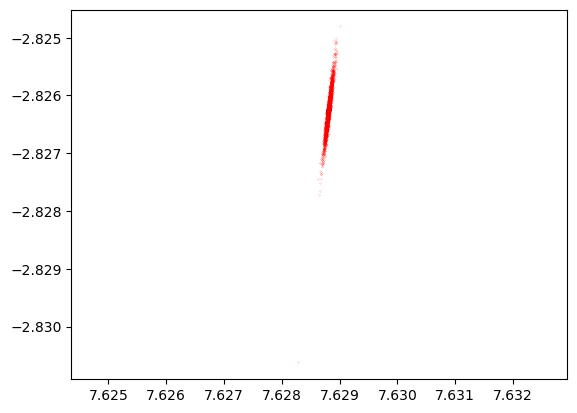

In [15]:
%matplotlib inline
plt.scatter(mcp_xv[:,0][bound],mcp_xv[:,2][bound],color='k',s=2)
plt.scatter(mcp_xv[:,0][~bound],mcp_xv[:,2][~bound],color='red',s=0.01)
plt.axis('equal')  
plt.show()

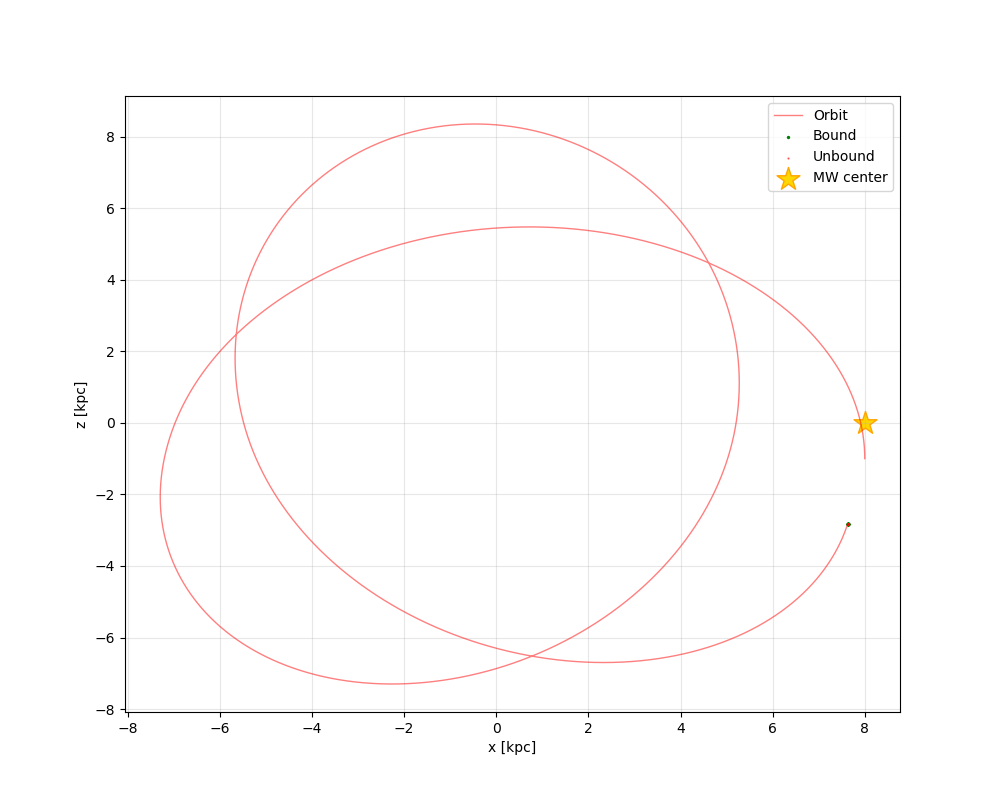

In [16]:
%matplotlib widget


traj = np.vstack(mc_traj)

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(traj[:,0], traj[:,2], 'r', linewidth=1, alpha=0.5, label='Orbit')
ax.scatter(mcp_xv[:,0][bound], mcp_xv[:,2][bound], color='green', s=2, label='Bound')
ax.scatter(mcp_xv[:,0][~bound], mcp_xv[:,2][~bound], color='red', s=0.5, alpha=0.5, label='Unbound')
ax.scatter([8], [0], marker='*', s=300, color='gold', edgecolors='orange', label='MW center')

ax.set_xlabel('x [kpc]')
ax.set_ylabel('z [kpc]')
ax.legend()
ax.set_aspect('auto')  
ax.grid(alpha=0.3)

plt.show()

In [17]:
np.sum(bound)/(np.sum(~bound)+np.sum(bound))

np.float64(0.0038)

In [ ]:
np.sum(bound)

In [ ]:
np.sum(bound_dist)/(np.sum(~bound_dist)+np.sum(bound_dist))


In [ ]:
np.sum(bound_energy)/(np.sum(~bound_energy)+np.sum(bound_energy))